# Introduction to Dimensionality Reduction

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from sklearn.decomposition import PCA
from scipy.stats import zscore
import pandas as pd
from itertools import combinations
from mpl_toolkits.axes_grid1 import make_axes_locatable
from seaborn import lmplot
import pickle
import random
import scanpy as sc
import anndata

#### A walk on the beach

<center><img src="beach.jpeg" width="600"></center>
<div style="text-align: center"> source: https://www.publicdomainpictures.net/en/free-download.php?image=shadows-on-the-beach&id=177457 </div>

#### Looking for repetition: a recipe book

<center><img src="recipes2.png" width="800"></center>

#### Nonlinearities during dimensionality reduction: calculating body mass index

The body mass index (BMI) is calculated form a person's height and weight as an indicator of body composition. The BMI is calculated as follows:

$$
BMI = \frac{weight}{height^2}
$$

The units of BMI are therefore $m / kg^2$. Calculating BMI has the benefit of reducing two variables into a single variable, amounting to dimensionality reduction.

Now, could we say that calculating BMI amounts to *linear* dimensionality reduction?

How about the following?

$$
\begin{align}
l.BMI = log(BMI) &= log(\frac{weight}{height^2})\\
&= log(weight) - log(height^2)\\
&= log(weight) - 2log(height)\\
&= l.weight - l.height\\
\\
l.BMI &= l.weight - l.height
\end{align}
$$

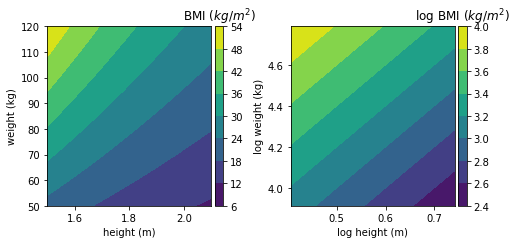

In [54]:
## Contour plots of BMI in relation to weight and height

fig, ax = plt.subplots(1,2, figsize=[7,3.5])

heights = np.linspace(1.5, 2.1, 100)
weights = np.linspace(50, 120, 100)
hv, wv = np.meshgrid(heights, weights)
bmisv = wv / hv**2
hwb = np.stack([hv.flatten(), wv.flatten(), bmisv.flatten()]).T

log_heights = np.log(np.linspace(1.5, 2.1, 100))
log_weights = np.log(np.linspace(50, 120, 100))
lhv, lwv = np.meshgrid(log_heights, log_weights)
log_bmisv = lwv - 2*lhv
log_hwb = np.stack([lhv.flatten(), lwv.flatten(), log_bmisv.flatten()]).T

s0 = ax[0].contourf(hv, wv, bmisv); ax[0].set_xlabel('height (m)'); ax[0].set_ylabel('weight (kg)')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(s0, cax=cax, orientation='vertical')
cbar0.ax.set_title('BMI ($kg/m^2$)')

s1 = ax[1].contourf(lhv, lwv, log_bmisv); ax[1].set_xlabel('log height (m)'); ax[1].set_ylabel('log weight (kg)')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(s1, cax=cax, orientation='vertical')
cbar1.ax.set_title('log BMI ($kg/m^2$)')

plt.tight_layout(); plt.show()

## Principal Components Analysis (PCA)

With PCA, data from a high-dimensional space (e.g. 2D, a plane) can be projected onto a lower-dimensional space (e.g. 1D, a line).

<center><img src="pca_proj.jpeg" width="500"></center>
<div style="text-align: center"> source: https://programmathically.com/principal-components-analysis-explained-for-dummies/ </div>

Here is an example of 3D data projected onto a 2D plane.

<center><img src="pca.png" width="800"></center>
<div style="text-align: center"> source: https://www.publicdomainpictures.net/en/free-download.php?image=shadows-on-the-beach&id=177457 </div>

In [55]:
## Import iris dataset
from sklearn import datasets
iris = datasets.load_iris()

In [56]:
## Store data in pandas DataFrame
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

## Rename columns
iris_df['target'] = iris_df['target'].map({0:iris.target_names[0], 1:iris.target_names[1], 2:iris.target_names[2]})
iris_df.rename(columns = {'target':'species'}, inplace=True)

## Display data and list species' names
display(iris_df)
print(iris_df['species'].unique())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


['setosa' 'versicolor' 'virginica']


In [57]:
## Extract numerical values in arrays
x = iris_df.iloc[:,:-1].values
x

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [58]:
## Normalize data: zero mean & unit variance

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)
x_trunc = x[:,:-1]  ## first three features, for visualization

Before scaling


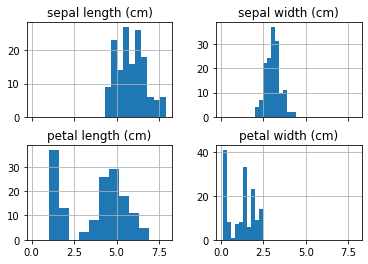

After scaling


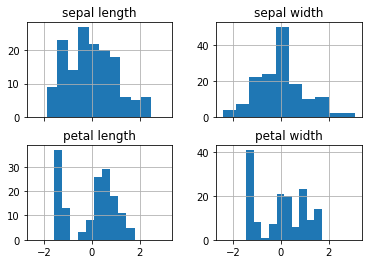

In [59]:
## Compare histograms of features before and after applying the standard scaler

print('Before scaling')
iris_df.hist(sharex=True); plt.show()

print('After scaling')
pd.DataFrame(x, columns=iris_df.columns[:-1].str.strip(' (cm)')).hist(sharex=True); plt.show()

Text(0.5, 0, 'petal length (cm)')

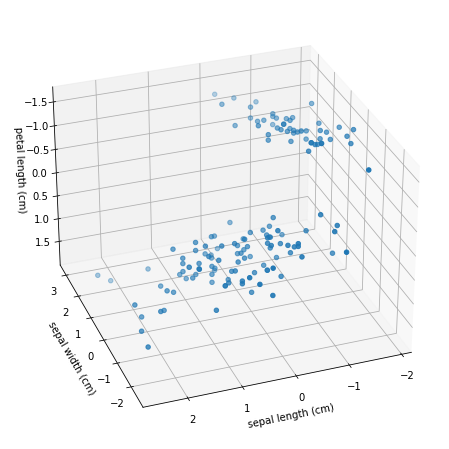

In [60]:
## Visualize truncated data containing first three features
fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

ax.scatter(x_trunc[:,0], x_trunc[:,1], x_trunc[:,2]);

ax.set_xlabel(iris_df.columns[0]); ax.set_ylabel(iris_df.columns[1]); ax.set_zlabel(iris_df.columns[2])

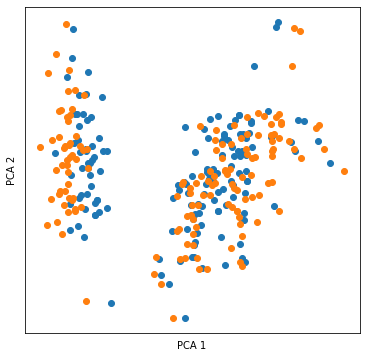

In [61]:
## Compare 2D projections of full vs truncated data

fig, ax = plt.subplots(1,1,figsize=[6.,6.])
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2')
ax.set_xticks([]); ax.set_yticks([])

## 2D PCA projection of truncated data
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x_trunc)
ax.scatter(x_2d[:,0], x_2d[:,1])

## 2D PCA projection of full data
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)
ax.scatter(x_2d[:,0], x_2d[:,1])

plt.show()

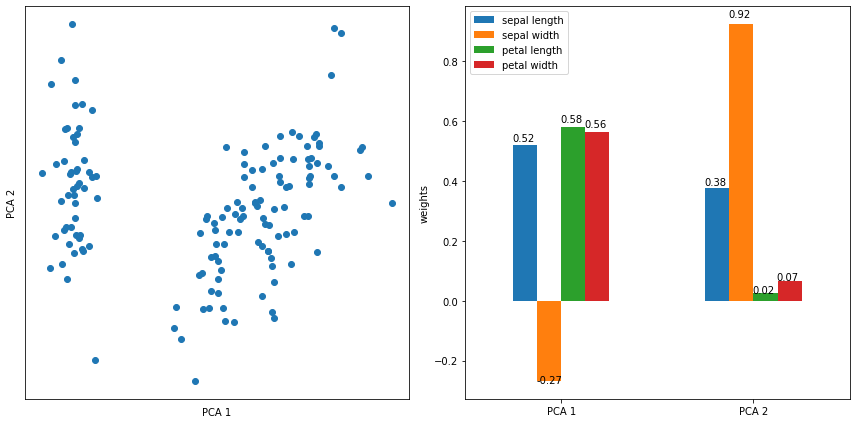

In [62]:
## Show "manual" 2D PCA projection alongside PCA weights for different features

fig, ax = plt.subplots(1,2,figsize=[12,6])
ax[0].set_xlabel('PCA 1')  # proportion of variance explained by PCA component 1
ax[0].set_ylabel('PCA 2')  # proportion of variance explained by PCA component 2
ax[0].set_xticks([]); ax[0].set_yticks([])

## Matrix multiplication to obtain projection
x_2d_manual = x @ pca.components_[:2,:].T
ax[0].scatter(x_2d_manual[:,0], x_2d_manual[:,1]);

## Barplot of components' weights
bp = pd.DataFrame(pca.components_, columns=iris_df.columns[:-1].str.strip(' (cm)'), index=['PCA 1', 'PCA 2']).plot.bar(ax=ax[1], rot=0);

bp.set_ylabel('weights');
for p in ax[1].patches: ax[1].annotate(str(round(p.get_height(), 2)), (p.get_x()-0.005, p.get_height()*1.025))

plt.tight_layout()
plt.show()

$$
PCA.1 = 0.52 * sepal.length - 0.27 * sepal.width + 0.58 * petal.length + 0.56 * petal.width\\
PCA.2 = 0.38 * sepal.length - 0.92 * sepal.width + 0.02 * petal.length + 0.07 * petal.width
$$

In [63]:
## "Manual" 2D projection - project dimensions individually for one data point

xi = x[0,:]
print('Feature values of xi:', xi, '\n')
print('Weights for PCA 1:', pca.components_[0,:])
print('Weights for PCA 2:', pca.components_[1,:], '\n')

xi_1 = (xi * pca.components_[0,:]).sum()  # project onto 1st component
xi_2 = (xi * pca.components_[1,:]).sum()  # project onto 2nd component

print('Projection of xi onto PCA 1 and PCA 2 - manual computation:', np.float32([xi_1, xi_2]))
print('Projection of xi onto PCA 1 and PCA 2 - automatic computation:', np.float32(x_2d[0,:]))

Feature values of xi: [-0.90068117  1.01900435 -1.34022653 -1.3154443 ] 

Weights for PCA 1: [ 0.52106591 -0.26934744  0.5804131   0.56485654]
Weights for PCA 2: [0.37741762 0.92329566 0.02449161 0.06694199] 

Projection of xi onto PCA 1 and PCA 2 - manual computation: [-2.2647028  0.4800266]
Projection of xi onto PCA 1 and PCA 2 - automatic computation: [-2.2647028  0.4800266]


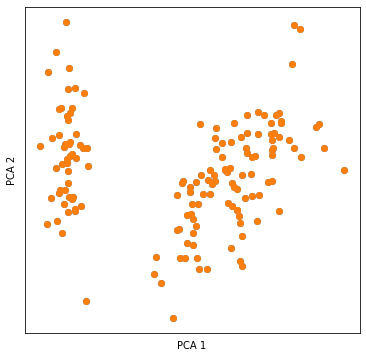

In [64]:
## Compare full "manual" 2D projection to automatic 2D projection

fig, ax = plt.subplots(1,1,figsize=[6.,6.])
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2')
ax.set_xticks([]); ax.set_yticks([])

## 2D PCA projection of full data
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)
ax.scatter(x_2d[:,0], x_2d[:,1])

## 2D PCA projection of full data - matrix multiplication
x_2d_manual = x @ pca.components_.T
ax.scatter(x_2d_manual[:,0], x_2d_manual[:,1]);

plt.show()

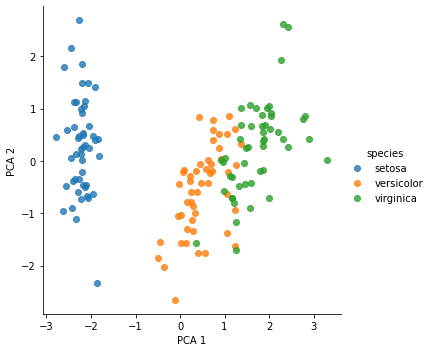

In [65]:
## Color data points by species

iris_df_2d = pd.DataFrame(data = np.c_[x_2d, iris_df['species']], columns=['PCA 1', 'PCA 2', 'species'])
lmplot(x='PCA 1', y='PCA 2', data=iris_df_2d, hue='species', fit_reg=False);

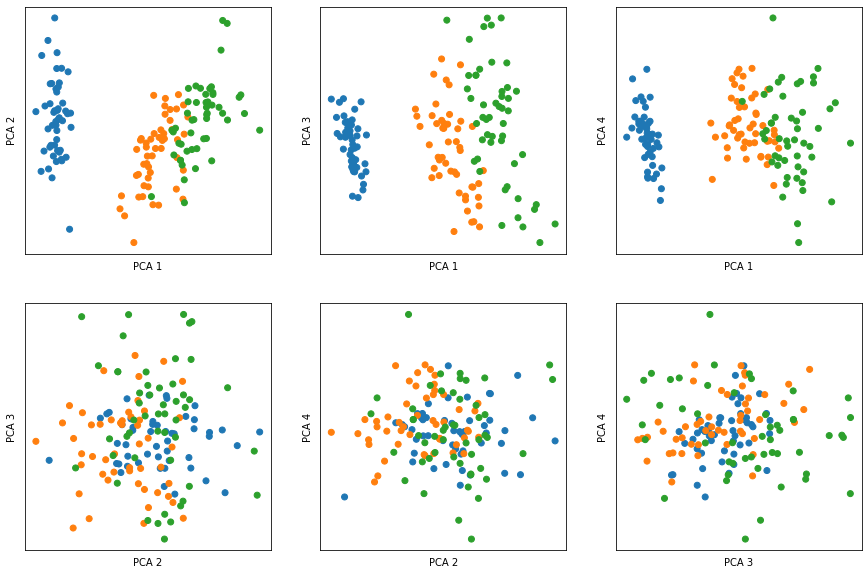

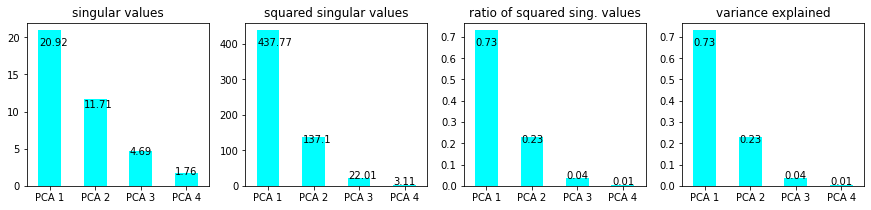

In [66]:
## Compute 4 PCA components rather than just 2 components
pca_4d = PCA(n_components=4)
x_4d = pca_4d.fit_transform(x)

## Plot all 6 possible 2D PCA projections
p = np.arange(4)
pcombs = list(combinations(p,2))

plt_cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'setosa':plt_cols[0], 'versicolor':plt_cols[1], 'virginica':plt_cols[2]}

_, ax = plt.subplots(2,3, figsize=[15.,10.])
for i, pcomb in enumerate(pcombs):
    axi = np.unravel_index(i, ax.shape)
    ax[axi].scatter(x_4d[:,pcomb[0]], x_4d[:,pcomb[1]], c=iris_df['species'].map(colors))
    
    ax[axi].set_xlabel('PCA ' + str(pcomb[0]+1)); ax[axi].set_ylabel('PCA ' + str(pcomb[1]+1))
    ax[axi].set_xticks([]); ax[axi].set_yticks([])
    

## Plot singular values and related quantities
fig, ax = plt.subplots(1,4,figsize=[15.,3.])

sv_1 = pca_4d.singular_values_
sv_2 = pca_4d.singular_values_**2
sv_3 = pca_4d.singular_values_**2 / (pca_4d.singular_values_**2).sum()
sv_4 = pca_4d.explained_variance_ratio_

pd.DataFrame(sv_1, index=['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']).plot.bar(ax=ax[0], rot=0, legend=False, color='cyan', title='singular values');
for p in ax[0].patches: ax[0].annotate(str(round(p.get_height(), 2)), (p.get_x()+0.01, p.get_height()*0.9))
pd.DataFrame(sv_2, index=['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']).plot.bar(ax=ax[1], rot=0, legend=False, color='cyan', title='squared singular values');
for p in ax[1].patches: ax[1].annotate(str(round(p.get_height(), 2)), (p.get_x()+0.01, p.get_height()*0.9))
pd.DataFrame(sv_3, index=['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']).plot.bar(ax=ax[2], rot=0, legend=False, color='cyan', title='ratio of squared sing. values');
for p in ax[2].patches: ax[2].annotate(str(round(p.get_height(), 2)), (p.get_x()+0.01, p.get_height()*0.9))
pd.DataFrame(sv_4, index=['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']).plot.bar(ax=ax[3], rot=0, legend=False, color='cyan', title='variance explained');
for p in ax[3].patches: ax[3].annotate(str(round(p.get_height(), 2)), (p.get_x()+0.01, p.get_height()*0.9))

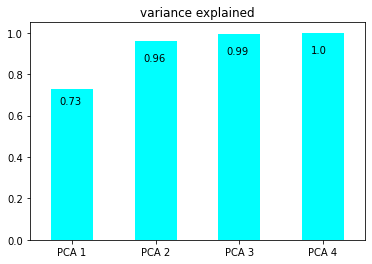

In [67]:
## Plot cumulative sum of variances explained by the PCA components

_, ax = plt.subplots(1,1)
pd.DataFrame(sv_4.cumsum(), index=['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']).plot.bar(ax=ax, rot=0, legend=False, color='cyan', title='variance explained');
for p in ax.patches: ax.annotate(str(round(p.get_height(), 2)), (p.get_x()+0.1, p.get_height()*0.9))

#### The biplot

We've plotted the projections of individual samples onto the 2D PCA represenation, effectively achieving dimensionality reduction for the purposes of e.g. data visualization. We've also *separately* plotted the weights of the PCA components to visualize how different features are weighted when projecting data onto the 2D representation.

Alternatively, one can visualize *both* the samples' projection onto the 2D representation as well as the features' weights simultaneously via a **biplot**.

In [68]:
def biplot(score, coeff , y, variables, extend=1):
    '''
    
    ***** Author: Serafeim Loukas, serafeim.loukas@epfl.ch *****
    https://ai.plainenglish.io/how-to-implement-pca-with-python-and-scikit-learn-22f3de4e5983
    
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(8,6), dpi=100)
    classes = np.unique(y)
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], label=l) # color based on group
    plt.legend()
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0] * extend, coeff[i,1] * extend, color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* extend, coeff[i,1] * extend, variables[i], color = 'k', ha = 'center', va = 'center',fontsize=10)
    plt.xlabel("PCA {}".format(1), size=14)
    plt.ylabel("PCA {}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)
    
    
def bisubplot(score, coeff , y, variables, pcomb, ax, extend=1):
    '''
    
    ***** Author: Serafeim Loukas, serafeim.loukas@epfl.ch *****
    https://ai.plainenglish.io/how-to-implement-pca-with-python-and-scikit-learn-22f3de4e5983
    
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    classes = np.unique(y)
    for s,l in enumerate(classes):
        ax.scatter(xs[y==l],ys[y==l], label=l) # color based on group
    ax.legend()
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        ax.arrow(0, 0, coeff[i,0] * extend, coeff[i,1] * extend, color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        ax.text(coeff[i,0]* extend, coeff[i,1] * extend, variables[i], color = 'k', ha = 'center', va = 'center',fontsize=10)
    ax.set_xlabel("PCA {}".format(pcomb[0]+1), size=14)
    ax.set_ylabel("PCA {}".format(pcomb[1]+1), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    ax.set_xlim([-limx,limx])
    ax.set_ylim([-limy,limy])
    ax.grid()
    ax.tick_params(axis='both', which='both', labelsize=14)

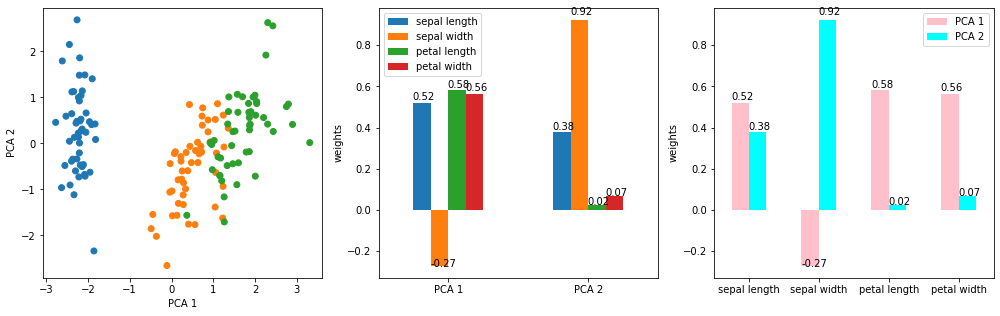

In [69]:
## Barplot of components' weights

fig, ax = plt.subplots(1,3,figsize=[14.,4.5])

ax[0].scatter(x_2d[:,0], x_2d[:,1], c=iris_df['species'].map(colors))
ax[0].set_xlabel('PCA 1'); ax[0].set_ylabel('PCA 2')

## PCA weights as plotted previously
bp = pd.DataFrame(pca.components_, columns=iris_df.columns[:-1].str.strip(' (cm)'), index=['PCA 1', 'PCA 2']).plot.bar(ax=ax[1], rot=0);

bp.set_ylabel('weights');
for p in ax[1].patches:
    ax[1].annotate(str(round(p.get_height(), 2)), (p.get_x()-0.005, p.get_height()*1.025))
    
## PCA weights, plotted by feature rather than PCA component
bp = pd.DataFrame(pca.components_.T, columns=['PCA 1','PCA 2'], index=iris_df.columns[:-1].str.strip(' (cm)')).plot.bar(ax=ax[2], rot=0, color=['pink','cyan']);

bp.set_ylabel('weights');
for p in ax[2].patches:
    ax[2].annotate(str(round(p.get_height(), 2)), (p.get_x()-0.005, p.get_height()*1.025))
    
plt.tight_layout()
plt.show()

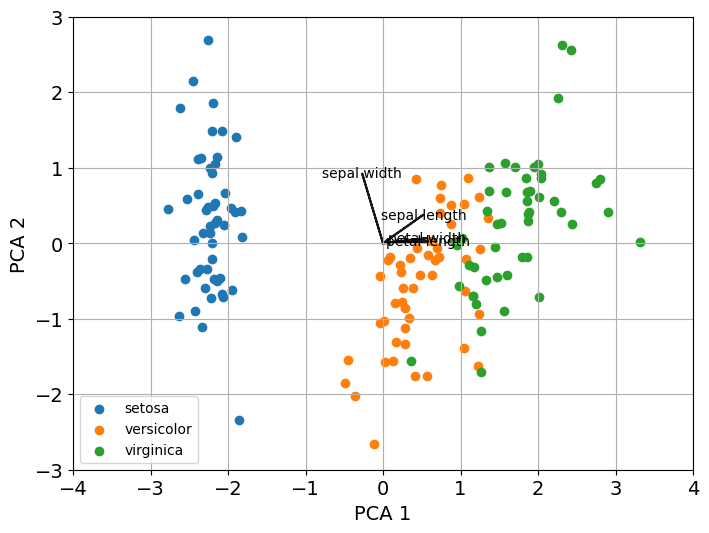

In [70]:
## Create biplot
biplot(x_2d, pca.components_.T, iris_df['species'], iris_df.columns[:-1].str.strip(' (cm)'), extend=1)

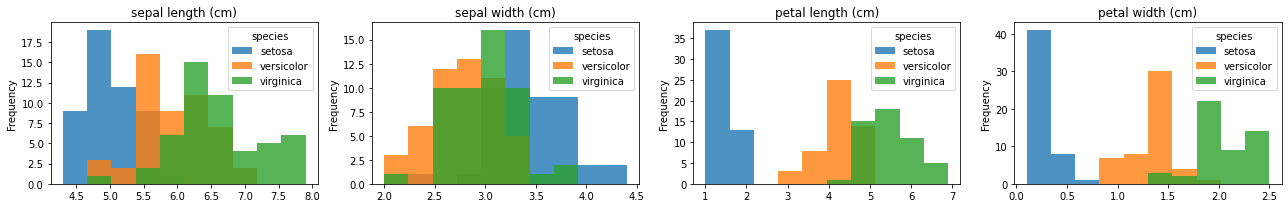

In [71]:
## Histograms of original features, grouped by species
fig, ax = plt.subplots(1,4,figsize=[18,3])
for c,col in enumerate(iris_df.columns[:-1]):
    h = iris_df.pivot(columns='species', values=col).plot.hist(alpha=0.8, title=col, ax=ax[c])

plt.tight_layout()
plt.show()

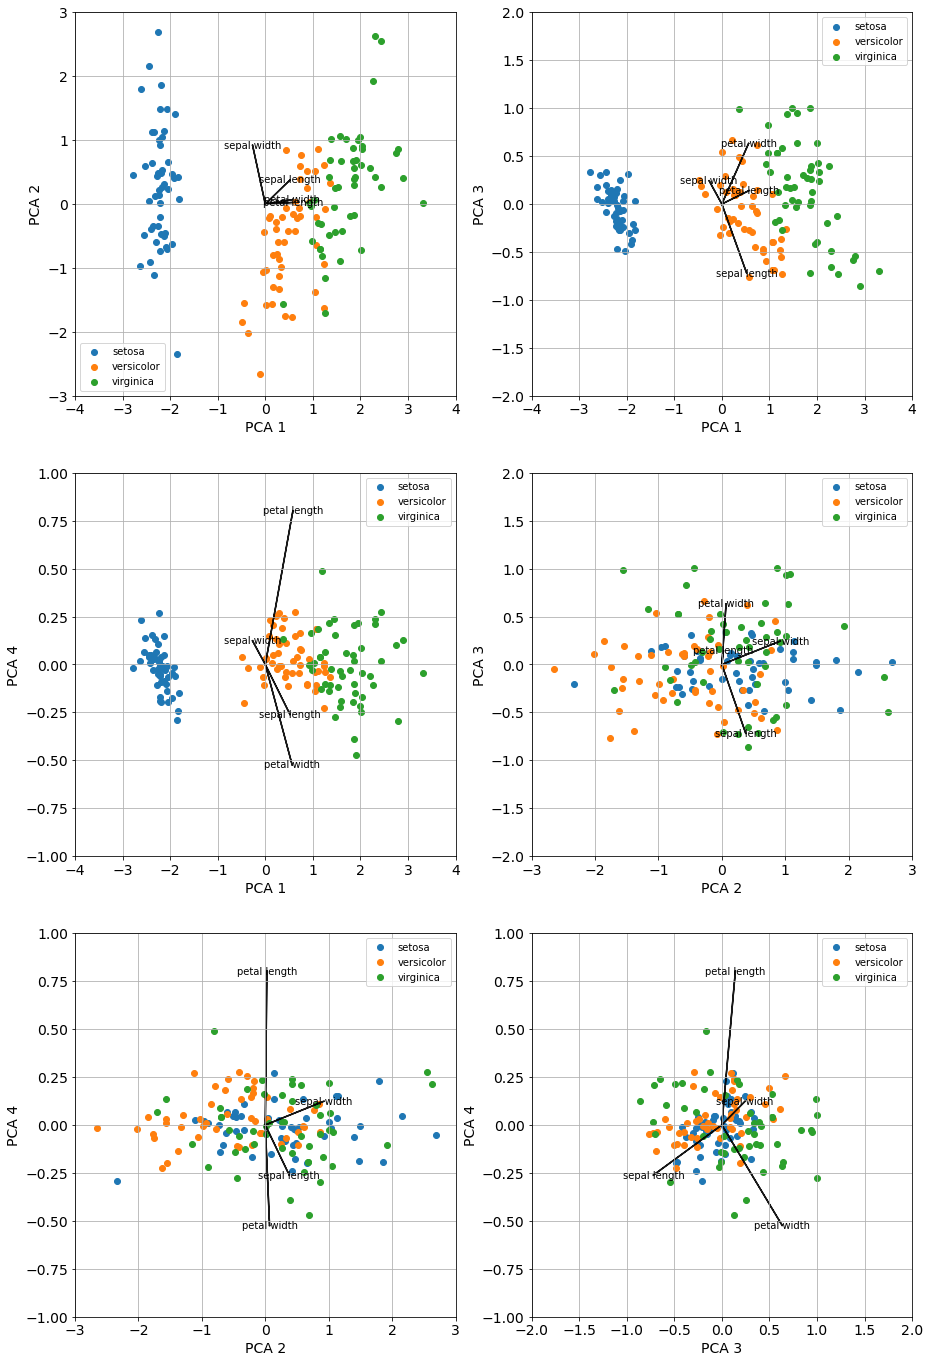

In [72]:
## Plot all 6 possible biplots arising from the 4 PCA components

_, ax = plt.subplots(3,2, figsize=[15.,24.])
for i, pcomb in enumerate(pcombs):
    axi = np.unravel_index(i, ax.shape)
    bisubplot(x_4d[:,pcomb], pca_4d.components_[pcomb,:].T, iris_df['species'], iris_df.columns[:-1].str.strip(' (cm)'), pcomb, ax[axi], extend=1)

#### Kernel PCA

PCA provides *linear* components which can be unsuitable for data with non-linear structures. Non-linear functions called *kernels* can be used to represent data such that PCA can provide suitable linear components of that non-linear representation. This method is termed **Kernel PCA**.

<img src="kpca.png" width="900">
<div style="text-align: center"> source: https://www.cs.mcgill.ca/~dprecup/courses/ML/Lectures/ml-lecture13.pdf </div>

#### Probabilistic PCA
PCA does not attempt to model noise which accompany its components. In **Probabilistic PCA**, a noise variance term $\sigma^2$ accounts for random variations within its components, allowing projections against its components with varying spreads. Probabilistic PCA can thus model both the linear structure and noise components of its components. Due to its probabilistic nature, Probabilistic PCA can also be used as a generative model. Note that Probabilistic PCA can be viewed as a special case of **Factor Analysis**.

<img src="ppca.png" width="1000">
<div style="text-align: center"> source: https://www.youtube.com/watch?v=lJ0cXPoEozg </div>

### Independent Component Analysis (ICA)

PCA provides *orthogonal* components / coordinates, which can limit the modelling capacities of PCA. On the other hand, such ICA components are not constrained to be orthogonal which provides ICA with more "flexibility".

<img src="pca_vs_ica.png" width="800">
<div style="text-align: center"> source: https://brainvision.com/applications/eeg/ </div>

#### Electroencephalography (EEG) data analysis
 
 The EEG is a brain recording modality where electrodes are placed on the scalp/head to measure fluctuations in bioelectical potentials. Hence, every electrode measures a time-varying signal.
 
  <img src="eeg_image.png" width="400">
  <div style="text-align: center"> source: https://brainvision.com/applications/eeg/ </div>

Import EEG data using [MNE Python](https://mne.tools/stable/index.html) analysis package. We will be using open-source data which has been reported in:

[Babayan, A., Erbey, M., Kumral, D. et al. *A mind-brain-body dataset of MRI, EEG, cognition, emotion, and peripheral physiology in young and old adults.* Sci Data 6, 180308 (2019).](https://www.nature.com/articles/sdata2018308)

In [73]:
## Load EEG data
eeg = mne.io.read_raw_eeglab("sub-010321_EC_downsamp.set")
eeg.annotations.delete( np.arange( len(eeg.annotations.description) ) )  # remove annotations, not important

Reading /Users/dmannk/OneDrive - McGill University/Autre/MiCM-2022/MiCM2022_Dim_Reduction/sub-010321_EC_downsamp.fdt


/var/folders/_b/33sf477j6nx3hg4j2g9dcwfm0000gn/T/ipykernel_740/2567534245.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab("sub-010321_EC_downsamp.set")
/var/folders/_b/33sf477j6nx3hg4j2g9dcwfm0000gn/T/ipykernel_740/2567534245.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab("sub-010321_EC_downsamp.set")


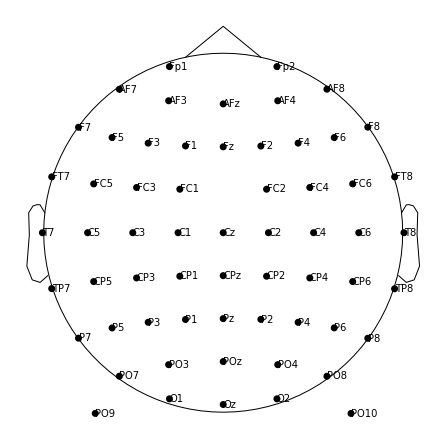

Using matplotlib as 2D backend.
Opening raw-browser...


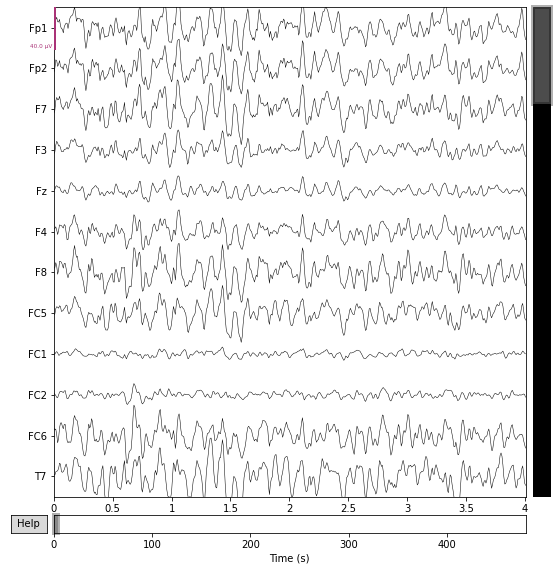

In [74]:
## Plot EEG electrode layout and EEG signals
eeg.plot_sensors(show_names=True, sphere=90);
eeg.plot(n_channels=12, duration=4);  # recommend plotting using "notebook" plotting backend, i.e. %matplotlib notebook

From the time-series plots, it seems that many time-series are alike. Perhaps there's a way to find patterns and have a more succinct representation of our data. One way to find these patterns is to use **Independent Components Analysis** (ICA) on our EEG data.

  <img src="eeg_ica.jpeg" width="500">
  <div style="text-align: center"> source: https://sccn.ucsd.edu/~jung/Site/EEG_artifact_removal.html </div>

In [75]:
## Compute ICA on EEG data
num_comps = 15  # choose number of patterns, or "components"

ica = ICA(n_components=num_comps, random_state=97)
ica.fit(eeg)

Fitting ICA to data using 61 channels (please be patient, this may take a while)


/var/folders/_b/33sf477j6nx3hg4j2g9dcwfm0000gn/T/ipykernel_740/3060443037.py:5: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(eeg)


Selecting by number: 15 components
Fitting ICA took 1.3s.


Method,fastica
Fit,30 iterations on raw data (59988 samples)
ICA components,15
Explained variance,99.8 %
Available PCA components,61
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=15, n_times=59988
    Range : 0 ... 59987 =      0.000 ...   479.896 secs
Ready.
Opening ica-browser...


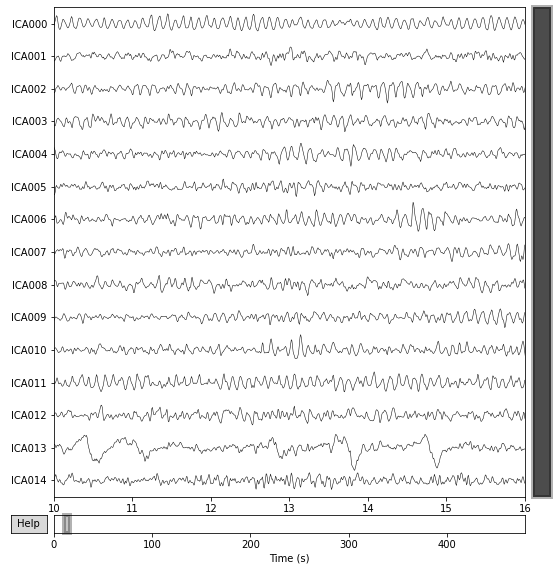

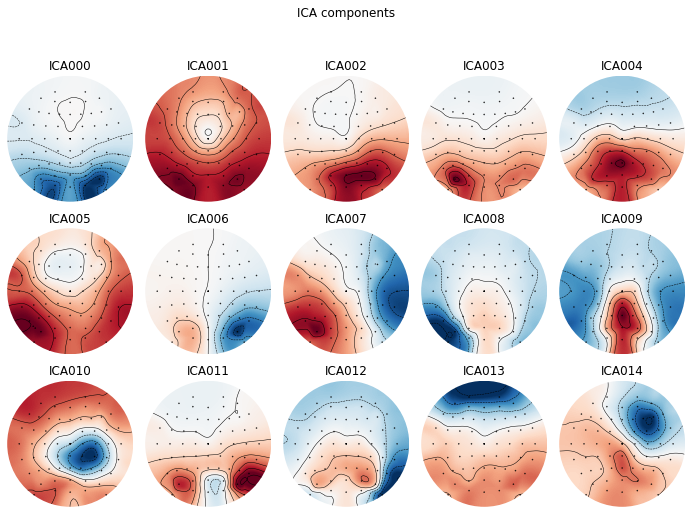

In [76]:
## Plot ICA components
ica.plot_sources(eeg, start=10, stop=16);
ica.plot_components();

In [77]:
## Compute PCA on EEG data
num_comps = 15  # choose number of patterns, or "components"

eeg_ts = eeg.get_data().T
pca = PCA(n_components=num_comps)
pca_data_ts = pca.fit_transform(eeg_ts)

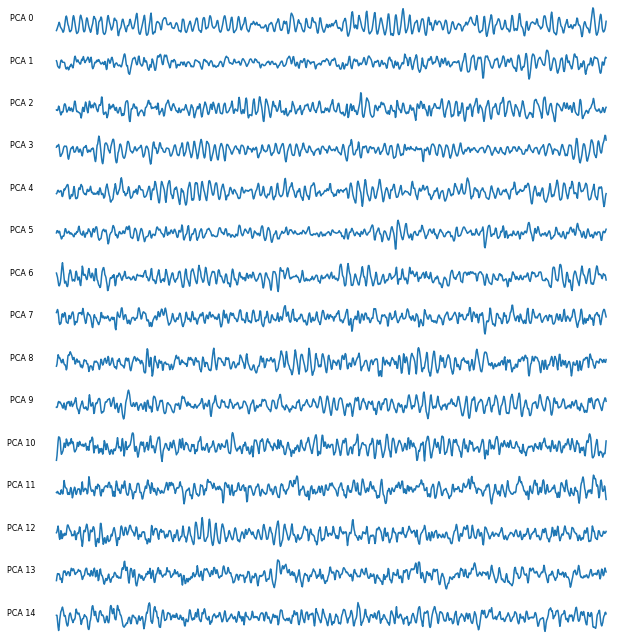

In [78]:
## Plot PCA components
len_plot = 1000     # choose time-series length for plotting purposes

num_plots = pca_data_ts.shape[1]
plt.figure(figsize=[9.,9.])

for i in range(num_plots):
    ax = plt.subplot( num_plots , 1, i+1 )
    plt.plot(zscore(pca_data_ts)[:len_plot,i])
    
    ax.set_ylabel("PCA {}".format(i), fontsize=8, rotation=0)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
plt.tight_layout()
plt.show()

### Nonlinear dimensionality reduction: t-SNE and UMAP

Linear dimensionality reduction methods such as PCA may be incapable of properly displaying data in a low-dimensional space (e.g. 2D). As previously discussed, kernel PCA leverages nonlinear transformations (i.e. kernels) such that the resulting representation is ammenable to standard PCA. However, kernel PCA requires a pre-defined kernel function to obtain a suitable nonlinear representation.

We will now explore two nonlinear dimensionality reduction methods which do not require such pre-defined kernels. These are:
1. t-distributed Stochastic Neighbor Embedding (**t-SNE**)
2. Uniform Manifold Approximation and Projection (**UMAP**)

Essentially, t-SNE and UMAP aim to preserve the "similarities" between pairs of datapoints. In other words, points which are "similar" in high-dimensional space should remain "similar" in low-dimensional space, where similarities are quantified kernels computed over distances. The concept of a *graph* is thus relevant for t-SNE and UMAP.

<img src="umap.png" width="800">
.
<div style="text-align: center"> source: https://umap-learn.readthedocs.io/en/latest/parametric_umap.html </div>

Although UMAP and t-SNE are very similar methods for embedding high-dimensional data into low-dimensional space, they have their differences. These methods use different kernels to quantify distances, symmetrize distances differently, have different number of parameters, and initialize low-dimensional embeddings differently. To the last point, t-SNE initializes low-dimensional embeddings randomly, whereas UMAP does so using spectral embedding. UMAP should thus provide much more stable and reproducible results compared to t-SNE.

Another (debated) difference between t-SNE and UMAP is the ability to preserve *global* structure in addition to *local* structure. One way of understanding this distinction is to view the graph structure in low-dimensional space as a set of attractive and repulsive forces between datapoints. The low-dimensional embedding is obtained once the forces equilibrate, similar to a set of springs left at its minimum energy equilibrium.

<center><img src="spring_graph.png" width="400"></center>
<div style="text-align: center"> source: Dr Laleh Haghverdi - sc-sys-med Summer School (31 May, 2022) </div>

#### Warning: speculative
In t-SNE, the balance between attractive and repulsive forces are achieved via the minimization of the Kullback-Leibler divergence, whereas minimization in UMAP is achieved via cross-entropy. The latter directly accounts for repulsive forces between dis-similar points whereas the Kullback-Leibler divergence does not. This difference between cross-entropy (UMAP) and Kullback-Leibler divergence (t-SNE) perhaps accounts for the better preservation of global structure in UMAP, although other theoretically-grounded reasons are also at play.

**Note**: t-SNE and UMAP are primarily used as *data visualization* methods and should generally not be used for other downstream purposes usually associated with dimensionality reduction such as with PCA.

**Note**: Clustering is often performed separately using e.g. the Louvain or Leiden algorithm. Datapoints embedded within the low-dimensional t-SNE/UMAP space are then colour-coded by cluster label.

#### t-SNE and UMAP on scRNA-seq data
t-SNE and UMAP are often used in the analysis of single-cell RNA sequencing (scRNA-seq) data which is very high dimensional, e.g. d = 20'000 genes. scRNA-seq data from the mouse prancreas will be used here for demonstration.

In [79]:
## Import and format data

random.seed(10)

# mouse pancreas single-cell dataset
# read in data and cell type labels
with open('MP.pickle', 'rb') as f:
    df = pickle.load(f)

with open('MP_genes.pickle', 'rb') as f:
    genes = pickle.load(f)

df.set_index('Unnamed: 0', inplace=True)  # set first column (cell ID as the index column)
sample_id = pickle.load(open('cell_IDs.pkl', 'rb'))
df = df.loc[list(sample_id), :]

X = df[genes].values  # extract the N x M cells-by-genes matrix

sample_info = pd.read_csv('sample_info.csv')

mp_anndata = anndata.AnnData(X=X)
mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values
celltype_one_hot = pd.get_dummies(mp_anndata.obs['Celltype'], prefix='Celltype').values

N = X.shape[0]  # number of single-cell samples
K = len(sample_info['assigned_cluster'].unique())  # number of topics
M = X.shape[1]  # number of genes

display(mp_anndata)

AnnData object with n_obs × n_vars = 1886 × 4194
    obs: 'Celltype'

#### t-SNE

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


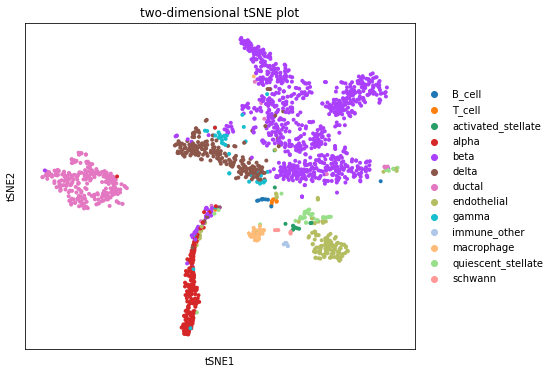

In [80]:
## Compute and plot 2D t-SNE projection
_, ax = plt.subplots(figsize=(7, 6))

sc.tl.tsne(mp_anndata, perplexity=30)
sc.pl.tsne(mp_anndata, color=["Celltype"], ax=ax, title='two-dimensional tSNE plot')

#### The perplexity parameter in t-SNE

The *perplexity* parameter modulates the width of the Gaussian kernel used to quantify similarities between points based on their distance of separation. Larger perplexity values lead to wider Gaussian kernels, allowing greater similarity between points that are more distant from one another.

<center><img src="tsne_perplexity.png" width="800"></center>
<div style="text-align: center"> source: Dr Laleh Haghverdi - sc-sys-med Summer School (31 May, 2022) </div>

#### UMAP

In [ ]:
## Compute neighbor affinities
sc.pp.neighbors(mp_anndata, n_neighbors=30)

## Compute and plot 2D UMAP projection
_, ax = plt.subplots(figsize=(7, 6))

sc.tl.umap(mp_anndata, min_dist=0.1)
sc.pl.umap(mp_anndata, color=["Celltype"], ax=ax, title='two-dimensional UMAP plot')

#### Number of nearest neighbors and Minimum distance parameters in UMAP

UMAP relies on the initial construction of a high-dimensional graph which is then embedded in low-dimensional space. This high-dimensional graph relies on the **number of nearest neighbors** parameter (n_neighbors) which controls how many adjacent datapoints are used to construct adaptive similarity kernels. To estimate the low-dimensional embedding, UMAP relies on the **minimum distance** parameter to "re-calibrate" the similarities' sensitivity to more distant points.

In short, both parameters aim to balance local and global structures: *n_neighbors* does so during the initial contruction of the high-dimensional graph, whereas *min_distance* does so later during the search for a low-dimensional embedding. As such, altering *n_neighbors* has a more severe impact than *min_distance*.

<center><img src="umap_n_neighbors_min_dist.png" width="1000"></center>
<div style="text-align: center"> source: https://pair-code.github.io/understanding-umap/ </div>

**Note**: other parameters are at play for UMAP, but are considered less interpretable

#### Recommended reading and exercise:
- Understanding UMAP (and t-SNE): https://pair-code.github.io/understanding-umap/

- Fine-tuning UMAP visualizations: https://jlmelville.github.io/uwot/abparams.html

## Autoencoders

**Note**: overlap with MiCM's Introduction to ML in Python by Tugce Gurbuz!

#### A word about neural networks
Neural networks combine linear and non-linear transformations to obtain powerful hidden representations of data. These hidden representations serve many purposes such as regression, classification, probability density estimation, image segmentation, etc.

<center><img src="neuralnet.png" width="400"></center>
<div style="text-align: center"> source: https://en.wikipedia.org/wiki/Neural_network </div>

#### Autoencoders

Within the context of dimensionality reduction, autoencoders are a subclass of neural networks which contains a hidden layer whose size is *smaller* than that of the input layer. Moreover, the output layer of an autoencoder aims at *reconstructing* the data provided at the input layer.

<center><img src="autoencoder.png" width="700"></center>
<div style="text-align: center"> source: https://www.jeremyjordan.me/autoencoders/ </div>

One can analyse the learned variables contained within the hidden layer. In this way, we achieve dimensionality reduction since these hidden variables are smaller in number than the original input variables.

#### Variational Autoencoders

We've briefly discussed how PCA can be framed within a probabilistic setting, leading to Probabilistic PCA. Similarly, **variational autoencoders** (VAE) frame the autoencoder framework within a probabilistic setting. Rather than estimate hidden variables within the bottleneck layer, VAEs estimate *hidden probability distributions* from which hidden variables can be sampled from.

<center><img src="vae.png" width="700"></center>
<div style="text-align: center"> source: https://www.jeremyjordan.me/autoencoders/ </div>

These hidden probability distributions are often chosen to follow the Gaussian/Normal distribution. This design provides structure to the bottleneck layer while also accounting for variability which is inherent within the data. Defining probability distributions within the bottleneck layer also has interesting implications for data generation.

In [84]:
import keras
from keras import layers
from keras.datasets import mnist

**Note**: exercises adapted from: https://www.theaidream.com/post/an-introduction-to-autoencoder-and-variational-autoencoder-vae

#### MNIST data

<center><img src="mnist.jpeg" width="400"></center>
<div style="text-align: center"> source: https://github.com/cazala/mnist </div>

#### Construct and train autoencoder model

**Note**: There are three hidden layers in this model, where the middle bottleneck layer is called the *encoding* layer

In [86]:
# This is the size of our encoded representations
encoding_dim = 2  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
hidden_dim = 64

# This is our input image
input_img = keras.Input(shape=(784,))

# "encoded" is the encoded representation of the input
hidden_enc = layers.Dense(hidden_dim, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(hidden_enc)
ae_encoder = keras.Model(input_img, encoded, name='encoder')

# "decoded" is the lossy reconstruction of the input
encoded_inputs = keras.Input(shape=(encoding_dim,), name='z_sampling')
hidden_dec = layers.Dense(hidden_dim, activation='relu')(encoded_inputs)
decoded = layers.Dense(784, activation='sigmoid')(hidden_dec)
ae_decoder = keras.Model(encoded_inputs, decoded, name='decoder')

output_img = ae_decoder(ae_encoder(input_img))

autoencoder = keras.Model(input_img, output_img, name='ae')

#Now let's train our autoencoder to reconstruct MNIST digits.
#First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

(x_train, _), (x_test, y_test) = mnist.load_data()

#We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#Now let's train our autoencoder for 50 epochs:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

#After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2400 - val_loss: 0.2187
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2158 - val_loss: 0.2116
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2097 - val_loss: 0.2068
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2052 - val_loss: 0.2033
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2025 - val_loss: 0.2014
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2008 - val_loss: 0.2001
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1996 - val_loss: 0.1991
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1986 - val_loss: 0.1982
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1978 - val_loss: 0.1978
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.196

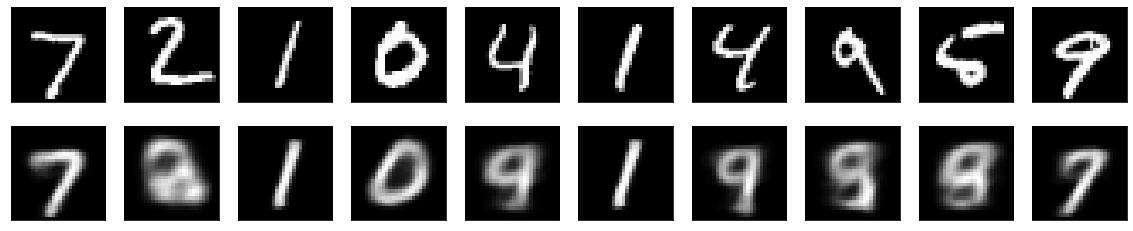

In [96]:
## Encode and decode some digits

encoded_imgs = ae_encoder.predict(x_test, verbose=0)
decoded_imgs = ae_decoder.predict(encoded_imgs, verbose=0)
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

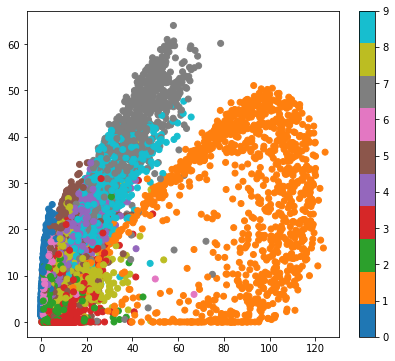

In [97]:
## Plot MNIST samples in bottleneck layer of autoencoder model

x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_test_encoded = ae_encoder.predict(x_test, verbose=0)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='tab10')
plt.colorbar()
plt.show()

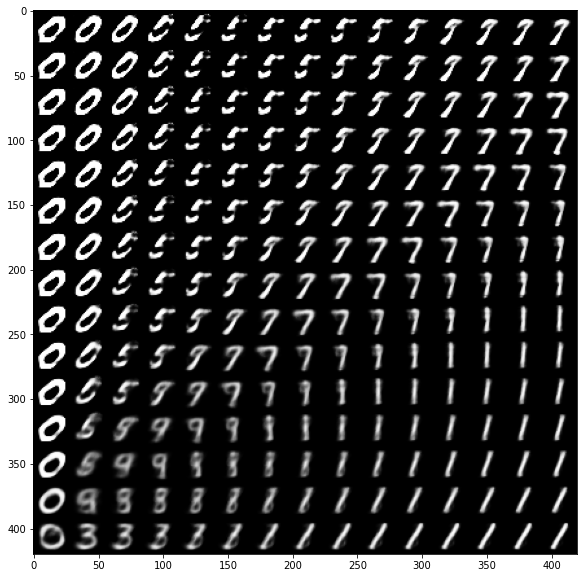

In [98]:
## Display a 2D manifold of the digits

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.flip(np.linspace(0, 120, n))
grid_y = np.linspace(0, 100, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = ae_decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

#### Construct and train variational autoencoder model

In [90]:
#First, here's our encoder network, mapping inputs to our latent distribution parameters:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

#We can use these parameters to sample new similar points from the latent space:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

#Finally, we can map these sampled latent points back to reconstructed inputs:
# Create encoder
vae_encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

vae_decoder = keras.Model(latent_inputs, outputs, name='decoder')

# Instantiate VAE model
outputs = vae_decoder(vae_encoder(inputs)[2])

vae = keras.Model(inputs, outputs, name='vae_mlp')

#We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


#We train our VAE on MNIST digits:
vae.fit(x_train, x_train,
        epochs=10,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 187.7629 - val_loss: 169.2284
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 167.5681 - val_loss: 165.0518
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 163.9052 - val_loss: 162.2125
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 161.3200 - val_loss: 160.3592
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 159.6687 - val_loss: 159.0291
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 158.5083 - val_loss: 158.2357
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 157.5779 - val_loss: 157.5568
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 156.7909 - val_loss: 157.0456
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 156.1407 - val_loss: 156.2630
Epoch 10/10
1875/1875 [=======================

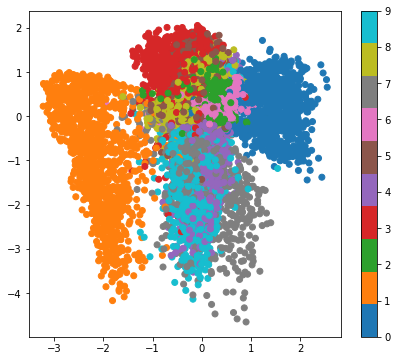

In [94]:
## Encode and decode some digits

x_test_encoded = vae_encoder.predict(x_test, verbose=0)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[0][:,0], x_test_encoded[0][:,1], c=y_test, cmap='tab10')
plt.colorbar()
plt.show()

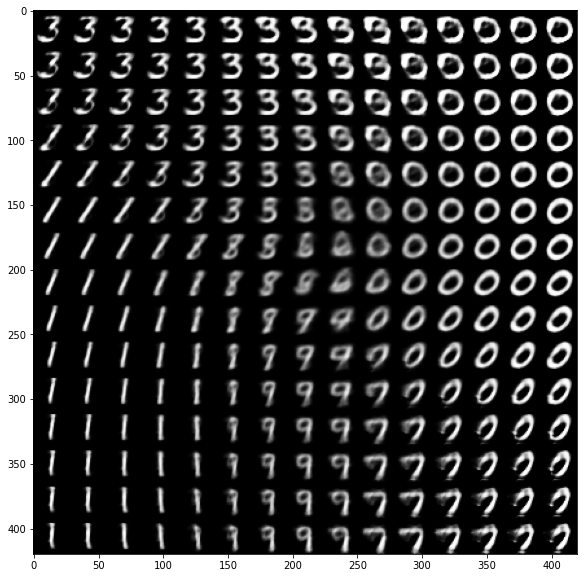

In [92]:
## Display a 2D manifold of the digits

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-15, 15]
grid_x = np.flip(np.linspace(-3, 3, n))
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae_decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Other topics in dimensionality reduction

1. Dimensionality reduction via latent associations between datasets
2. Tensor decompositions
3. Dimensionality reduction of autocorrelated data
4. Categorical and mixed data

#### Latent associations between two datasets

<center><img src="cca.png" width="400"></center>
<div style="text-align: center"> source: https://www.slideshare.net/blazf/canonical-correlation-analysis-319668 </div>

#### Tensor decomposition

<center><img src="tensor.png" width="800"></center>
<div style="text-align: center"> source: Hore et al. (2016) - Nature genetics </div>

#### Autocorrelated data

Many dimensionality reduction methods implicitly assume that the ordering of features is unimportant. However, this is not the case for autocorrelated signals such as EEG data where the ordering between features matters. Some methods such as Second-Order Blind Identification (SOBI) takes this ordering into account.

#### Categorical data
<center><img src="mca.jpeg" width="600"></center>
<div style="text-align: center"> source: Bannister (2019) - PLoS ONE </div>


For mixed data, where both numerical and categorical variables are present, one can use **Factor Analysis of Mixed Data** which combines PCA with Multiple Correspondance Analysis.